In [59]:
#let's import things you need

# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import odeint
# for nonlinear equations
from scipy.optimize import fsolve
from matplotlib.pyplot import cm
# needed to calculate (complex) squareroots of negative numbers
from scipy import sqrt,integrate
#nullcline
import PyDSTool as dst
from PyDSTool.Toolbox import phaseplane as pp
from PyDSTool import args
# to display plots in-line
%matplotlib inline


#import sympy for fixed points?
import sympy as sm

#widget
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In [60]:
# parameters
tau_e=20
tau_i=10
###########
#stimulus orientation
phi_1=45 
# phi_2=0 #if you need two stimuli
###########
j_ee = 0.044
j_ie = 0.042
j_ei = 0.023
j_ii = 0.018
sigm_ori=32
sigm_ff=30
k=0.04
n=2.0
N=180
c=10


In [114]:
#####################################
#from pedro's firing rate network
# time parameters
t0 = 0
tmax =100
tstep = 0.1
t = np.arange(t0,tmax,tstep)
    
#all the initials
r_e=np.zeros((N,t.shape[0]))
r_i=np.zeros((N,t.shape[0]))
in_e=np.zeros((N,t.shape[0]))
in_i=np.zeros((N,t.shape[0]))
w_ee =np.zeros((N,N))
w_ei=np.zeros((N,N))
w_ie=np.zeros((N,N))
w_ii=np.zeros((N,N))
r_e_ss=np.zeros((N,t.shape[0]))
r_i_ss=np.zeros((N,t.shape[0]))
c=np.arange(1,101,1)
ext_in=np.zeros((N,100))
R_e=np.zeros((N,c.shape[0]))
R_i=np.zeros((N,c.shape[0]))
R_e_n_e=np.zeros((N,c.shape[0]))
R_e_n_i=np.zeros((N,c.shape[0]))
R_i_n_e=np.zeros((N,c.shape[0]))
R_i_n_i=np.zeros((N,c.shape[0]))
R_e_t=np.zeros((N,c.shape[0]))
R_i_t=np.zeros((N,c.shape[0]))
sum_ext=np.zeros(c.shape[0])
sum_net_e=np.zeros(c.shape[0])
sum_net_i=np.zeros(c.shape[0])
sum_inp_e=np.zeros(c.shape[0])
sum_inp_i=np.zeros(c.shape[0])

#going to calculate the external input first
h_1=np.arange(1,181,1)
h_d=np.subtract(h_1,phi_1)
h=np.exp(-((h_d**2)/(2*(sigm_ff**2))))

#equations
#weights
w_1=np.arange(1,181,1)
w_c,w_r=np.meshgrid(w_1,w_1)
w_d=np.absolute(w_r-w_c)
w_ee=j_ee*np.exp(-((w_d**2)/(2*(sigm_ori**2))))
w_ie=j_ie*np.exp(-((w_d**2)/(2*(sigm_ori**2))))
w_ei=j_ei*np.exp(-((w_d**2)/(2*(sigm_ori**2))))
w_ii=j_ii*np.exp(-((w_d**2)/(2*(sigm_ori**2))))


#let's start euler
#this iteration may detect only the steady state value_so if you want r vs time, make another iteration for it
dt=t.shape[0]-1
for j in range(0,c.shape[0]):
    c_l=c[j]
    for i in range(1,t.shape[0]):
        r_e[:,i]=((-r_e[:,i-1]+r_e_ss[:,i-1])/tau_e)*tstep+r_e[:,i-1]
        r_i[:,i]=((-r_i[:,i-1]+r_i_ss[:,i-1])/tau_i)*tstep+r_i[:,i-1]
        in_e[:,i]=c_l*h+np.dot(w_ee,r_e[:,i])-np.dot(w_ei,r_i[:,i])
        in_i[:,i]=c_l*h+np.dot(w_ie,r_e[:,i])-np.dot(w_ii,r_i[:,i])
        in_e[in_e[:,i]<0,i]=0
        in_i[in_i[:,i]<0,i]=0
        r_e_ss[:,i]=k*np.power(in_e[:,i],n)
        r_i_ss[:,i]=k*np.power(in_i[:,i],n)
    ext_in[:,j]=c_l*h #external input
    R_e[:,j]=r_e[:,dt] #firing rate of E unit
    R_e_n_e[:,j]=np.dot(w_ee,r_e[:,dt]) #network E of E unit
    R_e_n_i[:,j]=np.dot(w_ei,r_i[:,dt]) #network I of E unit
    R_e_t[:,j]=in_e[:,dt] #I hope this is the net input of E unit
    R_i[:,j]=r_i[:,dt] #firing rate of I unit
    R_i_n_e[:,j]=np.dot(w_ie,r_e[:,dt]) #network E of I unit
    R_i_n_i[:,j]=np.dot(w_ii,r_i[:,dt]) #network I of I unit
    R_i_t[:,j]=in_i[:,dt] #I hope this is the net input of I unit
    sum_ext[j]=np.sum(c_l*h)
    sum_inp_e[j]=np.sum(R_e_t[:,j])
    sum_inp_i[j]=np.sum(R_i_t[:,j])
    sum_net_e[j]=sum_inp_e[j]-sum_ext[j]
    sum_net_i[j]=sum_inp_i[j]-sum_ext[j]
    



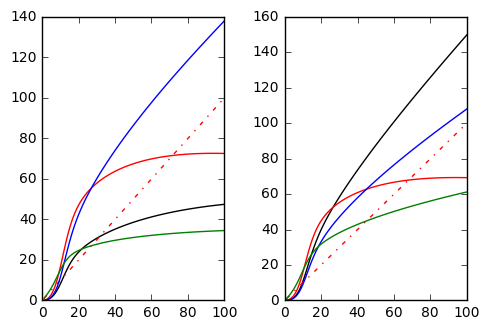

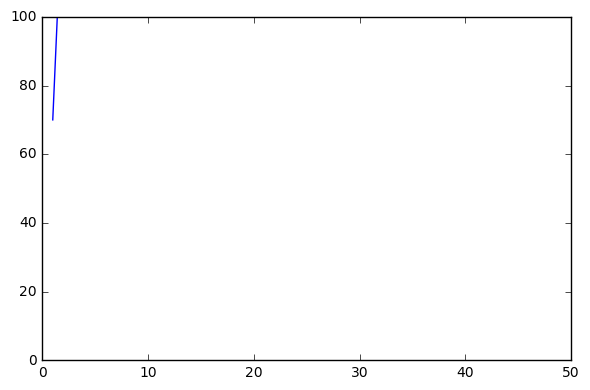

In [115]:
#before doing plot, let's do some calculations
#for firing rate vs input strength(h(x))
#use steady state firing rate
#external input
ch=ext_in[45,:]

#excitatory
efr_e=R_e[45,:]
enetw_e=R_e_n_e[45,:]
enetw_i=R_e_n_i[45,:]
einp=R_e_t[45,:]

#inhibitory
ifr_e=R_i[45,:]
inetw_e=R_i_n_e[45,:]
inetw_i=R_i_n_i[45,:]
iinp=R_i_t[45,:]

#plots
pllt=plt.figure(figsize=(5,4))
eunit=plt.subplot2grid((5,4), (0,0 ), colspan=2,rowspan=4)
plt.plot(c,efr_e,'-k',c,ch,'-.r',c,enetw_e,'-r',c,enetw_i,'-b',c,einp,'-g')

iunit=plt.subplot2grid((5,4), (0,2 ), colspan=2,rowspan=4)
plt.plot(c,ifr_e,'-k',c,ch,'-.r',c,inetw_e,'-r',c,inetw_i,'-b',c,iinp,'-g')
plt.tight_layout()

#percent of input
plt.figure()
plt.plot(c,sum_ext)
plt.tight_layout()
